# Reinforcement Learning Overview

This notebook implements value iteration and policy iteration.

## Markov Decision Process - MDP

In MDP, there is an agent. The agent choose an action $a_{t}$ at time $t$ and as a consequence, the environment changes.
Here the evniorment is world around the agent. After taking the action, the environment state changes to $s_{t+1}$.
A reward might be emitted associated with what just happened and then this process repeats. ![](nb_images/mdp.png)

So, there is a feedback cycle in that the next action you take, the next decision you make is in a situation that's the consiquence of what you did before.

## 1. Import libraries

In [72]:
import numpy as np
import gymnasium as gym
import gymnasium.spaces as spaces
import time
import torch
import matplotlib.pyplot as plt

In [2]:
# action mapping for display the final result
action_mapping = {
    3: '\u2191', # UP
    2: '\u2192', # RIGHT
    1: '\u2193', # DOWN
    0: '\u2190' # LEFT
}
print(' '.join([action_mapping[i] for i in range(4)]))

← ↓ → ↑


## 2. Setup GYM Env for playing

We define a function that will take a GYM environment and plays number of games according to given policy.

In [3]:
def play_episodes(environment, n_episodes, policy, random = False, categorial = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        environment: openAI GYM object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # flag to check if the game is finished
        terminated = False
        
        # reset the environment every time when playing a new episode
        state = environment.reset()[0]

        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = environment.action_space.sample()
            else:
                if categorial:
                    action = np.random.choice(len(policy[state]), p=policy[state])
                else:
                    action = policy[state] 

            # take the next step
            next_state, reward,  terminated, info = environment.step(action)[:-1]
            
            environment.render()
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state
            
            # if game is over with positive reward then add 1.0 in wins
            if terminated and reward == 1.0:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward
            

## 3. Solve for Value Iteration.

![](nb_images/value_iter.png)

In [4]:

def one_step_lookahead(env, state, V , discount_factor = 0.99):
    """
    Helper function to  calculate state-value function
    
    Arguments:
        env: openAI GYM environment object
        state: state to consider
        V: Estimated Value for each state. Vector of length nS
        discount_factor: MDP discount factor
        
    Return:
        action_values: Expected value of each action in a state. Vector of length nA
    """
    
    # initialize vector of action values
    action_values = np.zeros(env.action_space.n)
    
    # loop over the actions we can take in an environment 
    for action in range(env.action_space.n):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))
            
    return action_values

In [5]:
def update_policy(env, policy, V, discount_factor):
    
    """
    Helper function to update a given policy based on given value function.
    
    Arguments:
        env: openAI GYM environment object.
        policy: policy to update.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy: Updated policy based on the given state-Value function 'V'.
    """
    
    for state in range(env.observation_space.n):
        # for a given state compute state-action value.
        action_values = one_step_lookahead(env, state, V, discount_factor)
        
        # choose the action which maximizez the state-action value.
        policy[state] =  np.argmax(action_values)
        
    return policy
    

In [6]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM environment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        optimal_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize value fucntion
    V = np.zeros(env.observation_space.n)
    
    # iterate over max_iterations
    for i in range(max_iteration):
        
        #  keep track of change with previous value function
        prev_v = np.copy(V) 
    
        # loop over all states
        for state in range(env.observation_space.n):
            
            # Asynchronously update the state-action value
            #action_values = one_step_lookahead(env, state, V, discount_factor)
            
            # Synchronously update the state-action value
            action_values = one_step_lookahead(env, state, prev_v, discount_factor)
            
            # select best action to perform based on highest state-action value
            best_action_value = np.max(action_values)
            
            # update the current state-value fucntion
            V[state] =  best_action_value
            
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            # if values of 'V' not changing after one iteration
            if (np.all(np.isclose(V, prev_v))):
                print('Value converged at iteration %d' %(i+1))
                break

    # intialize optimal policy
    optimal_policy = np.zeros(env.observation_space.n, dtype = 'int8')
    
    # update the optimal polciy according to optimal value function 'V'
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return V, optimal_policy

## Test the Algorithim

In [7]:
environment = gym.make('FrozenLake-v1')
tic = time.time()
opt_V, opt_Policy = value_iteration(environment.env, max_iteration = 1000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Time to converge: {elapsed_time: 0.3} ms")
print('Optimal Value function: ')
print(opt_V.reshape((4, 4)))
print('Final Policy: ')
print(opt_Policy)
print(' '.join([action_mapping[int(action)] for action in opt_Policy]))

Value converged at iteration 341
Time to converge:  4.47e+02 ms
Optimal Value function: 
[[0.78538826 0.77836049 0.77368481 0.7713498 ]
 [0.78775777 0.         0.50562724 0.        ]
 [0.79250312 0.79963699 0.74472318 0.        ]
 [0.         0.86409247 0.93114742 0.        ]]
Final Policy: 
[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]
← ↑ ↑ ↑ ← ← ← ← ↑ ↓ ← ← ← → ↓ ←


/home/jackkert/anaconda3/envs/ics/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [8]:
n_episode = 10
wins, total_reward, avg_reward = play_episodes(environment, n_episode, opt_Policy, random = False)

/home/jackkert/anaconda3/envs/ics/lib/python3.11/site-packages/gymnasium/envs/toy_text/frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


In [9]:
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Total wins with value iteration: 9
Average rewards with value iteration: 0.9


## 4. Solve for Policy Iteration

# Helper functions

In [10]:
def policy_eval(env, policy, Q, discount_factor):
    """
    Helper function to evaluate a policy.
    
    Arguments:
        env: openAI GYM environment object.
        policy: policy to evaluate.
        Q: Estimated Value for each state-action pair. Table of shape N x A
        discount_factor: MDP discount factor.
    Return:
        policy_value: Estimated value of each state-action pair following a given policy and state-action value 'Q'. 
        
    """
    policy_value = np.zeros((env.observation_space.n, env.action_space.n))
    for state in range(env.observation_space.n):
        for action, action_prob in enumerate(policy[state]): # evaluate policy value over all actions
            for probablity, next_state, reward, info in env.P[state][action]:
                policy_value[state][action] += probablity * (reward + (discount_factor * np.max(Q[next_state])))
    
    return policy_value

In [11]:
def one_step_lookahead_categorial(env, state, Q , discount_factor = 0.99):
    """
    Helper function to  calculate state-value function
    
    Arguments:
        env: openAI GYM environment object
        state: state to consider
        Q: Estimated Value for each state-action pair. Table of shape N x A
        discount_factor: MDP discount factor
        
    Return:
        action_values: Expected value of each action in a state. Vector of length nA
    """
    
    # initialize vector of action values
    action_values = np.zeros(env.action_space.n) 
    # loop over the actions we can take in an environment 
    for action in range(env.action_space.n):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * np.max(Q[next_state])))
            
    return action_values

In [12]:
def policy_regularized_softmax(policy, temperature, Q_value):
    """
    Helper function for the policy-regularized softmax function.

    Arguments:
        policy: current evaluated policy
        temperature: temperature hyperparameter 
        Q_value: current Q value function
    Return:
        action_dist: Improved action probability distribution for the new policy.
    """
    # convert to torch tensor
    policy = torch.from_numpy(policy)
    Q_value = torch.from_numpy(Q_value)
    action_dist = torch.nn.functional.softmax(torch.log(policy) + temperature * Q_value)
    return action_dist 

# Update policy functions

In [29]:
def update_policy_categorial(env, policy, Q, discount_factor, temperature, improvement_operator = "argmax"):
    
    """
    Helper function to update a given policy based on given value function.
    
    Arguments:
        env: openAI GYM environment object.
        policy: categorial policy to update.
        Q: Estimated Value for each state-action pair. Table of shape N x S.
        discount_factor: MDP discount factor.
    Return:
        policy: Updated policy based on the given state-action value function 'Q'.
    """
    if improvement_operator == "None":
        return policy
    
    for state in range(env.observation_space.n):
        # for a given state compute state-action value.
        action_values = one_step_lookahead_categorial(env, state, Q, discount_factor)
        # choose the action which maximizez the state-action value.
        if improvement_operator == "argmax":
            best_action = np.argmax(action_values)
            one_hot_policy = np.zeros(env.action_space.n)
            one_hot_policy[best_action] = 1
            policy[state] = one_hot_policy
        elif improvement_operator == "policy-regularized_softmax":
            policy[state] = policy_regularized_softmax(policy[state], temperature, action_values)
        
    return policy
    

# Main loop

In [107]:
def policy_iteration(env, improvement_operator = "argmax", value_improvement_operator = "argmax", discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM environment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        Q: Optimal state-action value function. Table of N x A
        new_policy: Optimal policy. Table of N x A
    
    """
    # intialize the state-Value function
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    Q_copied = np.zeros((env.observation_space.n,env.action_space.n))
    # intialize a random implicit categorial policy
    random_actions = np.random.randint(0, 1000, (env.observation_space.n, env.action_space.n))
    policy = random_actions/random_actions.sum(axis = 1, keepdims = True)


    policy_prev = np.copy(policy)
    temperature = 1.0
    for i in range(max_iteration):
        # copy the policy
        copied_policy = np.copy(policy) # could also use policy_prev but for readability now this is fine.
        # improve copied policy with second improvement operator
        copied_policy = update_policy_categorial(env, copied_policy, Q_copied, discount_factor, temperature, improvement_operator=value_improvement_operator)
        # Evaluate copied policy 
        Q_copied = policy_eval(env, copied_policy, Q_copied, discount_factor)
        # evaluate given policy
        Q = policy_eval(env, policy, Q, discount_factor)
        # improve the main policy with Q_copied
        policy = update_policy_categorial(env, policy, Q_copied, discount_factor, temperature, improvement_operator=improvement_operator)
        
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
                print('policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)
            

            
    return Q, policy

## Test Policy Iteration

In [68]:
environment2 = gym.make('FrozenLake-v1') #, render_mode = "human")
tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_V2, opt_policy2 = policy_iteration(environment2.env, improvement_operator="policy-regularized_softmax", value_improvement_operator = "policy-regularized_softmax", discount_factor = 0.999, max_iteration = 10000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Time to converge: {elapsed_time: 0.3} ms")
print('Optimal Value function: ')
print(opt_V2.reshape((environment2.observation_space.n, environment2.action_space.n)))
print('Final Policy: ')
print(np.round(opt_policy2,2))
# Display the most likely policy in discrete action
print("Most likely actions taken by policy: ")
print(' '.join([action_mapping[(np.argmax(action))] for action in opt_policy2]))

/tmp/ipykernel_50809/1363818680.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_dist = torch.nn.functional.softmax(torch.log(policy) + temperature * Q_value)


Time to converge:  4.92e+04 ms
Optimal Value function: 
[[0.78553326 0.78320919 0.78320919 0.78242366]
 [0.52084109 0.51929558 0.51697151 0.77855409]
 [0.68537991 0.68460832 0.68306281 0.77391292]
 [0.51465441 0.51465441 0.51388281 0.77159582]
 [0.78789222 0.52630964 0.52552411 0.52395068]
 [0.         0.         0.         0.        ]
 [0.50573092 0.24801792 0.50573092 0.257713  ]
 [0.         0.         0.         0.        ]
 [0.52630964 0.53024911 0.52867568 0.79261722]
 [0.55170453 0.79972245 0.53578092 0.51195945]
 [0.74479855 0.57639015 0.47849097 0.43471597]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.55407058 0.59784558 0.86415315 0.57639015]
 [0.84586349 0.93117891 0.89143383 0.86911425]
 [0.         0.         0.         0.        ]]
Final Policy: 
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.26 0.48 0.  ]
 [0.58 0.   0.42 0.  ]
 [0.35 0.2  0.1

In [69]:
n_episode = 10
wins, total_reward, avg_reward = play_episodes(environment2, n_episode, opt_policy2, random = False, categorial = True)

In [70]:
print(f'Total wins with Policy iteration: {wins}')
print(f"Average rewards with Policy iteration: {avg_reward}")

Total wins with Policy iteration: 9
Average rewards with Policy iteration: 0.9


## Comparison between methods

In [71]:
environment_comparison = gym.make('FrozenLake-v1') #, render_mode = "human")

tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_Q_argmax_one, opt_policy_argmax_none = policy_iteration(environment_comparison.env, improvement_operator="argmax", value_improvement_operator = "None", discount_factor = 0.999, max_iteration = 10000)
toc = time.time()
argmax_none_elapsed_time = (toc - tic) * 1000
print(f"Time to converge argmax-none: {argmax_none_elapsed_time: 0.3} ms")

tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_Q_softmax_argmax, opt_policy_softmax_argmax = policy_iteration(environment_comparison.env, improvement_operator="policy-regularized_softmax", value_improvement_operator = "argmax", discount_factor = 0.999, max_iteration = 10000)
toc = time.time()
softmax_argmax_elapsed_time = (toc - tic) * 1000
print(f"Time to converge softmax-argmax: {softmax_argmax_elapsed_time: 0.3} ms")

tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_Q_softmax_softmax, opt_policy_softmax_softmax = policy_iteration(environment_comparison.env, improvement_operator="policy-regularized_softmax", value_improvement_operator = "policy-regularized_softmax", discount_factor = 0.999, max_iteration = 10000)
toc = time.time()
softmax_softmax_elapsed_time = (toc - tic) * 1000
print(f"Time to converge softmax-softmax: {softmax_softmax_elapsed_time: 0.3} ms")


policy converged at iteration 31
Time to converge argmax-none:  90.9 ms


/tmp/ipykernel_50809/1363818680.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_dist = torch.nn.functional.softmax(torch.log(policy) + temperature * Q_value)


Time to converge softmax-argmax:  4.6e+04 ms
Time to converge softmax-softmax:  5.25e+04 ms


In [87]:
comparison_episodes = 100
policies = [opt_policy_argmax_none, opt_policy_softmax_argmax, opt_policy_softmax_softmax]
elapsed_times = [argmax_none_elapsed_time, softmax_argmax_elapsed_time, softmax_softmax_elapsed_time]

wins_per_policy = []
total_rewards_per_policy = []
avg_rewards_per_policy = []

for policy in policies:
    n_wins, total_reward, avg_reward = play_episodes(environment_comparison, comparison_episodes, policy, random = False, categorial = True)
    wins_per_policy.append(n_wins)
    total_rewards_per_policy.append(total_reward)
    avg_rewards_per_policy.append(avg_reward)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


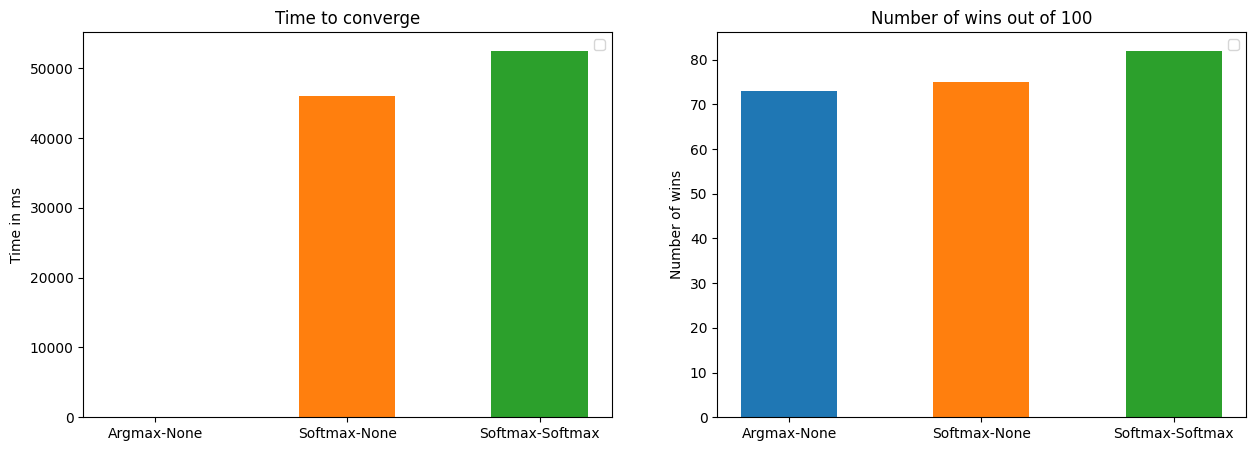

In [106]:
x = np.arange(len(elapsed_times))
width = 0.5  # Width of the bars

# Creating the bar plot
fig, ax = plt.subplots(1,2, figsize=(15, 5))
bar = ax[0].bar("Argmax-None", elapsed_times[0], width)
bar = ax[0].bar("Softmax-None", elapsed_times[1], width)
bar = ax[0].bar("Softmax-Softmax", elapsed_times[2], width)

# Adding labels, title, and ticksax.set_xlabel('Elapsed Time')
ax[0].set_ylabel('Time in ms')
ax[0].set_title('Time to converge')
ax[0].set_xticks(x)
ax[0].legend()

bar = ax[1].bar("Argmax-None", wins_per_policy[0], width)
bar = ax[1].bar("Softmax-None", wins_per_policy[1], width)
bar = ax[1].bar("Softmax-Softmax", wins_per_policy[2], width)

ax[1].set_ylabel('Number of wins')
ax[1].set_title('Number of wins out of 100')
ax[1].set_xticks(x)
ax[1].legend()
# Showing the plot
plt.show()